In [1]:
import nbsetup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ergodicpy as ep
from ergodicpy.plots import combine_legends
from functools import cached_property

In [136]:
def rand(i, x, y):
    "When dealing with many ensembles, randomise the difference in those ensembles"
    return np.random.uniform(x, y)

def mod(i, x, y, n=2):
    "When only 2 ensembles, convient to specify a garanteed distance"
    return x if i % n else y

class ChiScan:
    def __init__(self, func, variable_range, fixed=None, lazy=False,
                obs=1000, ensembles=2, trials=100, bins=10, cp=None):
        self.func = func
        self.variable_range = variable_range
        self.fixed = variable_range[0] if fixed is None else fixed
        self.obs = obs
        self.ensembles = ensembles
        self.trials = trials
        self.bins = bins
        self.cp = cp
        
        if not lazy:
            self.generate()
            self.analyse()
        
    def generate(self):
        """ Generates the observations """
        observations = {}
        s = mod if self.ensembles == 2 else rand
        for v in self.variable_range:
            observations[v] = []
            if self.cp: self.cp("generating", v)
            for t in range(self.trials):
                observations[v].append([
                    self.func(e, self.fixed, v, self.obs, s)
                        for e in range(self.ensembles)])
        self.observations = observations
    
    def analyse(self, count=None):
        """ Creates ErgodicEnsembles and stores results """
        self.ees = {}
        self.results = []
        for v, trials in self.observations.items():
            if self.cp: self.cp("analysing", v)
            self.ees[v] = []
            for trial in trials:
                if count is None:
                    count = self.bins
                bins = ep.binr(observations=trial, count=count)
                # ensemble
                ee = ep.ErgodicEnsemble(trial, bins)
                # chi2
                chi2, p, dof, expected = ee.chi2()
                cex = ce2x(ee.complexity)
                #cex2 = ce2x(ee.complexity**2, m=)
                
                self.results.append({
                    'ce': ee.complexity,
                    'cex': cex,
                    'ce^2': ee.complexity**2,
                    #'cex2': cex2,
                    'p': p,
                    'chi^2': chi2,
                    'obs': self.obs,
                    'v': v,
                    'pcex': 1 - stats.chi2.cdf(cex, dof),
                    #'pcex2': 1 - stats.chi2.cdf(cex2, dof)
                })
                self.ees[v].append(ee)
        if self.cp: self.cp("")
    
    def dataframe(self, notnull=True):
        df = pd.DataFrame([r for r in self.results])
        return df[pd.notnull(df['chi^2'])] if notnull else df
    
    @cached_property
    def df(self):
        return self.dataframe()
    
    def ratios(self, ax=None):
        df = self.dataframe()
        
        df['ratio'] = df['chi^2']/(df['ce'])
        sns.lineplot(data=df, x='v', y='ratio', label=self.ensembles, ax=ax)
    
    
    def plot(self, y='ce'):
        """ Plots ergodic complexity, chi2 and p-value against the variety of spreads """
        df = self.dataframe()
        fig, axes = plt.subplots(1, 2, figsize=(15,5))
        
        # plot complexity left graph
        g = sns.lineplot(data=df, x='v',y=y, ax=axes[0], color='mediumpurple', label=y)
        
        # chi2 on left graph, right axis
        ax02 = axes[0].twinx()
        sns.lineplot(data=df, x='v', y='chi^2', ax=ax02, color='forestgreen', label='chi^2')
        
        # p's on the right
        ax12 = axes[1]
        sns.lineplot(data=df, x='v',y='p', ax=ax12, color='darkcyan', label='chi p-value')
        sns.lineplot(data=df, x='v',y='pcex', ax=ax12, label='p(c)')
        #sns.lineplot(data=df, x='v',y='p(c^2)', ax=ax12, label='p(c^2)')
        
        ax12.axhline(y=0.05, color='grey', linestyle='dashed')
        ax12.axhline(y=0.1, color='grey', linestyle='dotted')
        
        # meta
        g.set_title("%s obs, %s bins, %s trials" % (self.obs, self.bins, self.trials))
        combine_legends(axes[0], ax02)
        #combine_legends(axes[1], ax12)
        #return fig
    
    def regress_curve(self, curve=1.0):
        df = self.dataframe(True)
        return self.regression(df['chi^2'], df['ce']**curve)
    
    def regression(self, x, y):
        from sklearn.linear_model import LinearRegression
        m = LinearRegression().fit(x.to_numpy().reshape(-1,1), y)
        return (m.coef_, m.intercept_)
    
    def correlate(self, curve=2.0, regress=True):
        """ Plots complexity against chi2 directly """
        fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,5))
        df = self.dataframe()
        
        # basic relationship plot
        g = sns.scatterplot(data=df, y='ce', x='chi^2', hue='v', ax=axes[0])
        
        # linearise the relationship
        key = 'ce^%s' % curve
        df[key] = df['ce']**curve
        sns.scatterplot(data=df, y=key, x='chi^2', hue='v', ax=axes[1])
        
        # add regression
        if regress:
            x = df['chi^2']
            m, c = self.regression(x, df[key])
            sns.lineplot(x=x, y=m*x+c, color='cyan', ax=axes[1])


In [141]:
def regression(x, y):
    from sklearn.linear_model import LinearRegression
    m = LinearRegression().fit(np.array(x).reshape(-1,1), np.array(y))
    return (m.coef_, m.intercept_)

In [93]:
def ce2x(ce, m = 0.00034939, c = np.pi):#0.00040071679435628536):
    return (ce/m)+c

In [94]:
power = lambda i,f,v,o,s: np.random.power(s(i,f,v),o)

# Chi^2 Relationship

When Chi^2's is less than ~200 (i.e. the system is not complex) the relationship appears to be that C_e^2 has a linear relationship with Chi^2.

- The top left graph shows Chi^2 and C_e for varying different distributions. i.e. comparing observations from power 2.0 against 2.2, 2.3 etc.
- The top right shows the Chi^2 p-value for these same distributions.
- The middle left shows Chi^2 against C_e^2.
- While the bottom left shows Chi^2 against C_e and bottom right shows Chi^2 against C_e^2.

In [137]:
x = [2,3,4,5,6,7,8,9,10,15,20]

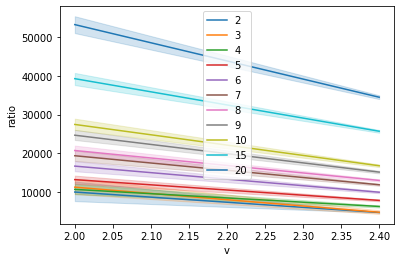

In [138]:
scans = []
for e in x:
    cs_power_26 = ChiScan(power, np.linspace(2,2.4,2), trials=100, obs=10000, ensembles=e, cp=nbsetup.cp)
    cs_power_26.ratios()
    scans.append(cs_power_26)

In [139]:
y = []
for s in scans:
    df = s.dataframe()
    means = df[df['v'] == 2.4].mean()
    y.append(means['chi^2']/means['ce'])

<AxesSubplot:>

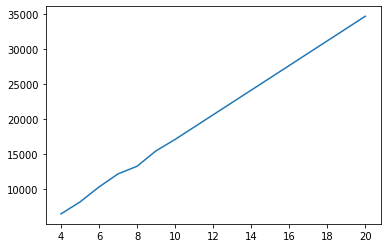

In [140]:
sns.lineplot(x=x[2:], y=y[2:])

In [158]:
m, c = regression(x=x[4:], y=y['ratio'][4:])

In [143]:
y = {'chi^2':[], 'ce':[], 'ratio':[]}
for s in scans:
    df = s.dataframe()
    means = df[df['v'] == 2.4].mean()
    y['chi^2'].append(means['chi^2'])
    y['ce'].append(means['ce'])
    y['ratio'].append(means['chi^2']/means['ce'])

<AxesSubplot:>

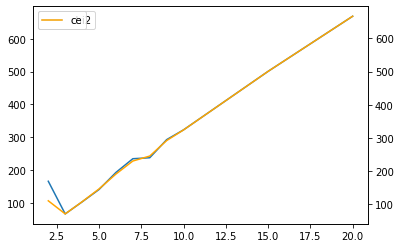

In [162]:
g = sns.lineplot(x=x, y=y['chi^2'], label='chi2')
npyce = np.array(y['ce'])
npx = np.array(x)
sns.lineplot(x=x, y=y['ce']*(m*npx+c), label='ce', ax=g.twinx(), color='orange')

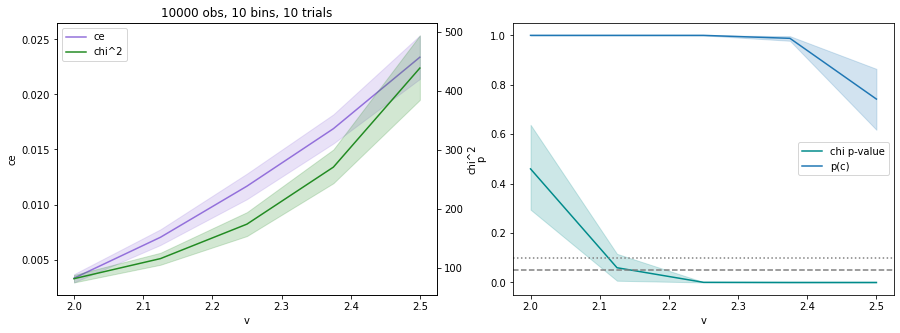

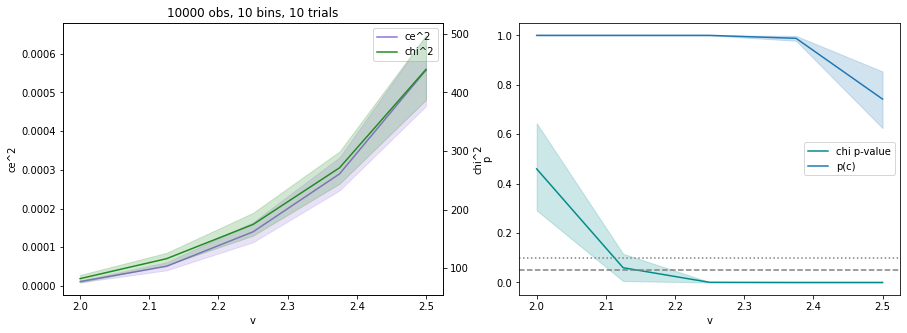

In [97]:
cs_power_26 = ChiScan(power, np.linspace(2,2.5,5), trials=10, obs=10000, ensembles=10, cp=nbsetup.cp)
cs_power_26.plot()
#cs_power_26.plot(y='cex')
cs_power_26.plot(y='ce^2')
#cs_power_26.correlate(2.0)

## Scaling

However, once the system becomes non-complex i.e. p < 0.05, the relationship then tends to become C_e is linear with Chi^2, with a constant regression. Now the bottom right graph is showing a C_e against C_e^2.

In [115]:
df

,ce,cex,ce^2,p,chi^2,obs,v,pcex
0,0.003840,14.132941,0.000015,5.010453e-01,35.313585,10000,2.0,0.999597
1,0.001915,8.621905,0.000004,9.623098e-01,22.436879,10000,2.0,0.999999
2,0.002657,10.745170,0.000007,8.499509e-01,27.337735,10000,2.0,0.999986
3,0.003577,13.380318,0.000013,5.377903e-01,34.545292,10000,2.0,0.999787
4,0.003267,12.492427,0.000011,5.295847e-01,34.716231,10000,2.0,0.999907
...,...,...,...,...,...,...,...,...
195,0.012430,38.718046,0.000155,7.986793e-04,68.838069,10000,2.4,0.347976
196,0.018876,57.168537,0.000356,8.964420e-20,172.730149,10000,2.4,0.013861
197,0.008394,27.166730,0.000070,1.753236e-04,74.387217,10000,2.4,0.855542
198,0.022950,68.827475,0.000527,2.068752e-25,204.328431,10000,2.4,0.000801


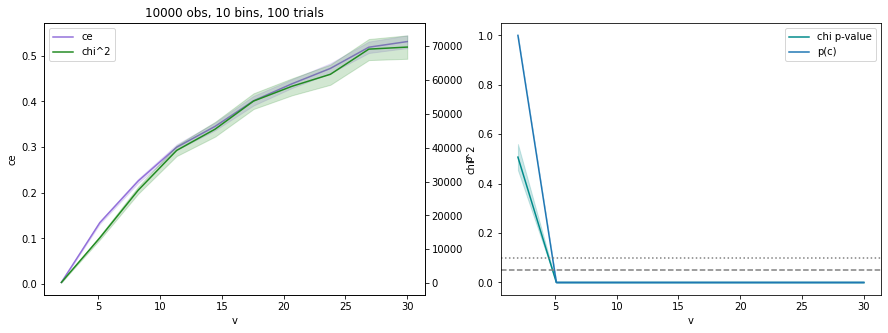

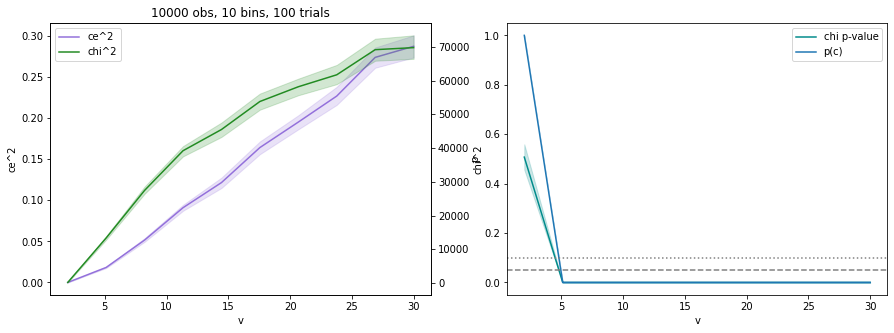

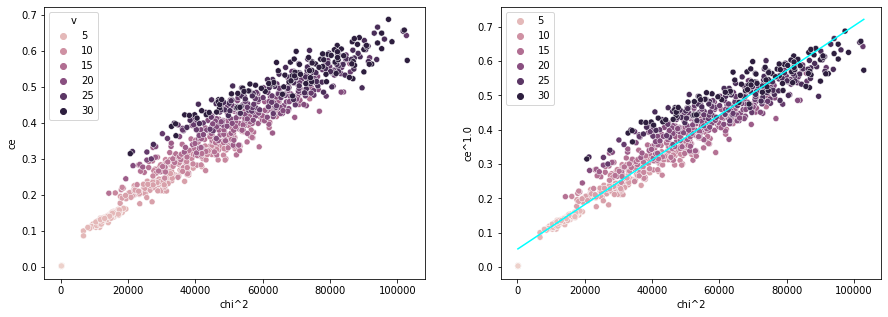

In [100]:
cs_power_220 = ChiScan(power, np.linspace(2,30,10), obs=10000, ensembles=20, cp=nbsetup.cp)
cs_power_220.plot()
cs_power_220.plot('ce^2')
cs_power_220.correlate(1.0)

The same is observed with distributions from other powers.

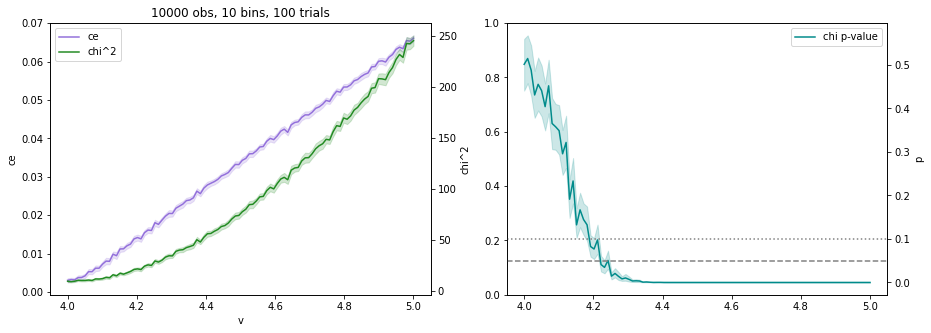

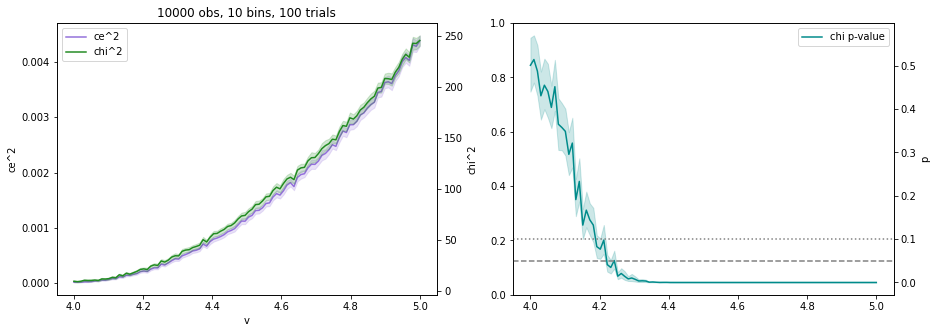

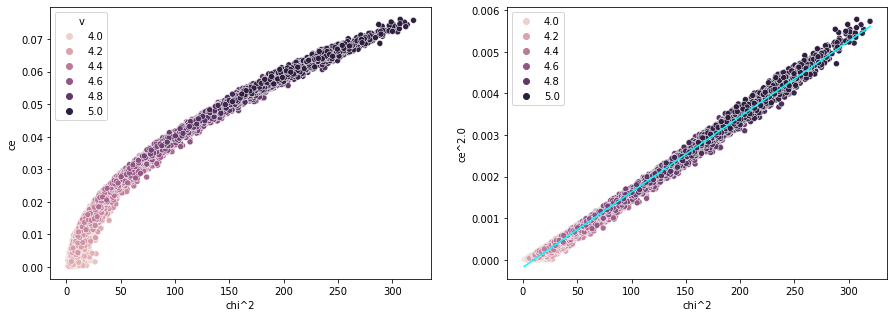

In [93]:
cs_power_46 = ChiScan(power, np.linspace(4,5,100), obs=10000, cp=nbsetup.cp)
cs_power_46.plot()
cs_power_46.plot('ce^2')
cs_power_46.correlate(2.0)

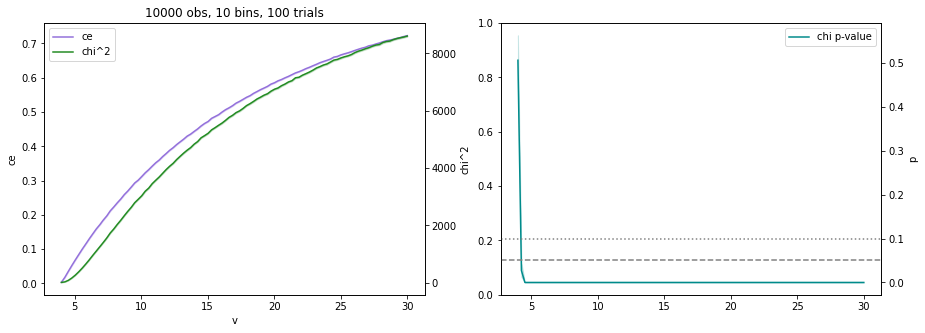

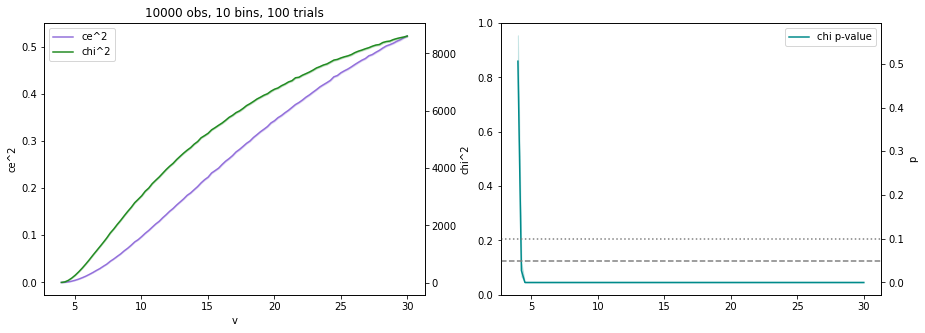

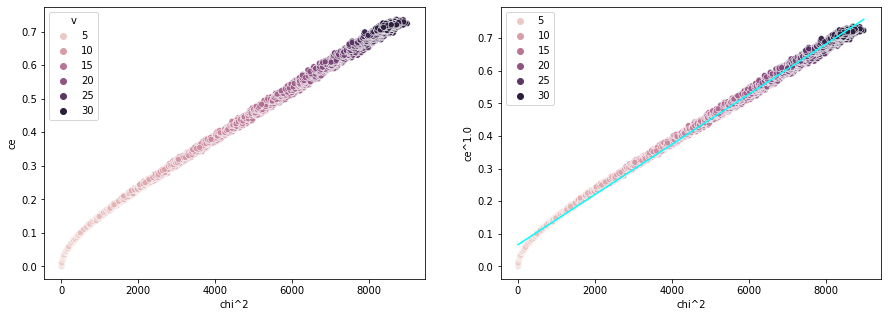

In [94]:
cs_power_46 = ChiScan(power, np.linspace(4,30,100), obs=10000, cp=nbsetup.cp)
cs_power_46.plot()
cs_power_46.plot('ce^2')
cs_power_46.correlate(1.0)

## Normal distribution

This same relationship for normal distributions isn't as evident.

In [104]:
normal05 = lambda i,f,v,o,s: np.random.normal(s(i, f, v),0.5,o)
normal005 = lambda i,f,v,o,s: np.random.normal(s(i, f, v),0.05,o)
#uniform = lambda i,f,v,o,s: np.random.uniform(f, v, o)

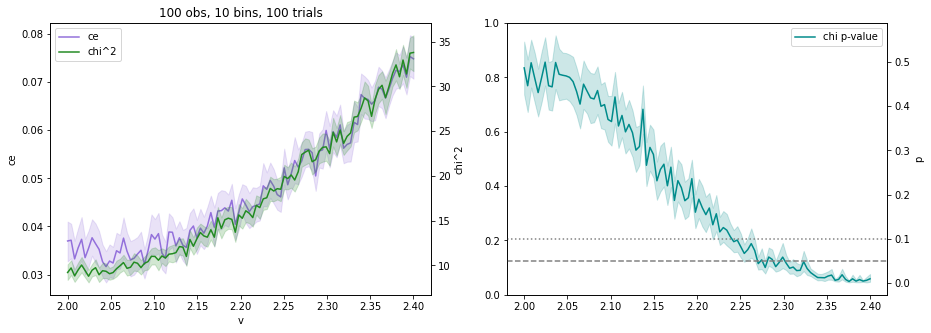

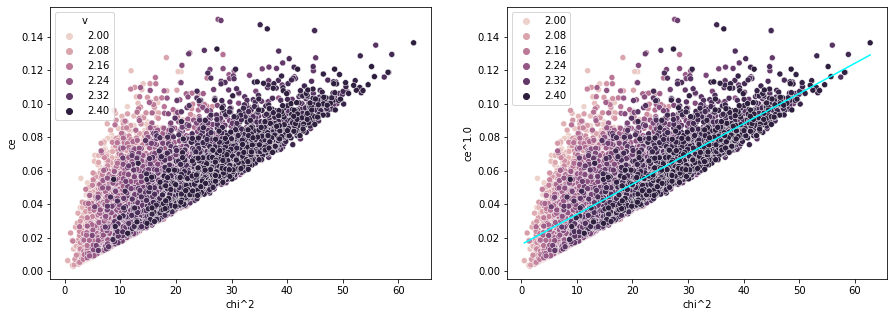

In [110]:
cs_normal = ChiScan(normal05, np.linspace(2,2.4,100), obs=100, cp=nbsetup.cp)
cs_normal.plot()
cs_normal.correlate(1.0)

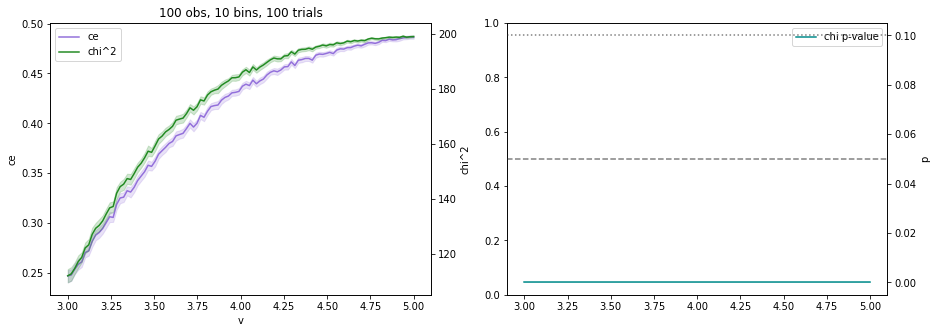

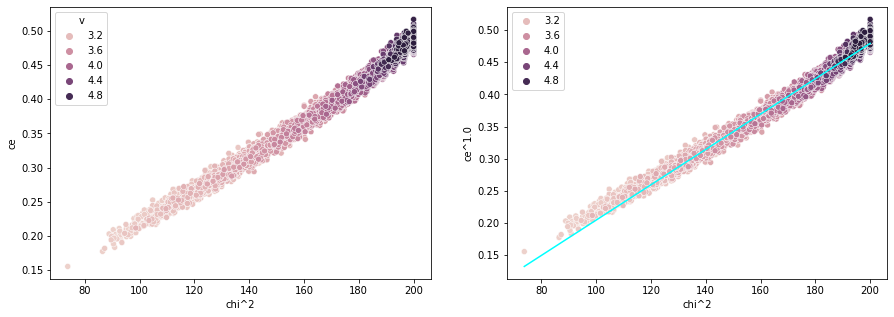

In [125]:
cs_normal = ChiScan(normal05, np.linspace(3,5,100), fixed=2, obs=100, cp=nbsetup.cp)
cs_normal.plot()
cs_normal.correlate(1.0)